## 🧠 LangGraph 기반 교육 요청 처리기:

### 🌟 단계 1: 사용자의 요청을 입력합니다.
예: "입문자를 위한 파이썬 커리큘럼 추천해줘"

### 🌟 단계 2: 어떤 유형인지 자동 분류합니다.
요청이 "수업인가?", "책 추천인가?", "일반 대화인가?" 판단합니다.

### 🌟 단계 3: 분류 결과에 따라 다른 처리 경로(노드)로 보냅니다.
- 수업이면 ➝ 커리큘럼 설계 노드
- 책 추천이면 ➝ 독서 추천 노드
- 설명 요청이면 ➝ 일반 대화 노드
- 그 외엔 ➝ 간단한 조언 노드

### 🌟 단계 4: 결과를 구조화된 형식으로 반환합니다.
→ 커리큘럼/책/답변/조언이 깔끔하게 출력됩니다!

**즉, 이 시스템은 "사용자 요청을 자동 분류하고, 알맞은 처리기로 보내는 똑똑한 라우터"입니다.**

In [2]:
from langchain_openai import ChatOpenAI

# LLM 인스턴스 생성
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

print("✅ LLM 초기화 완료!")

/Users/jinhohyeon/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


✅ LLM 초기화 완료!


# 📌 예제 1: 교육 요청 라우터 (Router Pattern)

## 핵심 개념
- 사용자 요청을 자동으로 분류
- 분류 결과에 따라 다른 노드로 라우팅
- 각 노드는 전문화된 작업 수행

In [3]:
from typing import TypedDict, List, Literal
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate

# 커리큘럼 구조 정의
class Syllabus(BaseModel):
    course_title: str = Field(description="과목 이름")
    level: str = Field(description="난이도")
    modules: List[str] = Field(description="주요 모듈")

# 독서 추천 구조 정의
class ReadingPick(BaseModel):
    book_title: str = Field(description="도서 제목")
    author: str = Field(description="저자")
    why_read: str = Field(description="추천 이유")

# 상태 정의
class ServiceState(TypedDict):
    request_text: str       # 사용자 입력
    intent_label: str       # 의도 라벨 (COURSE/BOOK/CHAT)
    syllabus: Syllabus      # 커리큘럼 결과
    reading: ReadingPick    # 독서 추천 결과
    general_note: str       # 일반 대화 결과

print("✅ 데이터 구조 정의 완료!")

✅ 데이터 구조 정의 완료!


In [4]:
# 1. 의도 분류 노드
def detect_intent(state: ServiceState):
    """사용자 요청을 COURSE/BOOK/CHAT 중 하나로 분류"""
    prompt = ChatPromptTemplate([
        ('system', '''사용자 요청을 다음 중 하나로 분류하세요:
1) 교육 과정/커리큘럼: 'COURSE'
2) 독서 추천: 'BOOK'
3) 일반 대화/설명: 'CHAT'
라벨 하나만 출력하세요.'''),
        ('user', '{request_text}')
    ])
    result = (prompt | llm).invoke(state)
    return {"intent_label": result.content}

# 2. 커리큘럼 설계 노드
def design_curriculum(state: ServiceState):
    """커리큘럼을 구조화하여 생성"""
    prompt = ChatPromptTemplate([
        ('system', '교육과정 설계 전문가로서 커리큘럼을 작성하세요.'),
        ('user', '{request_text}')
    ])
    chain = prompt | llm.with_structured_output(Syllabus)
    return {'syllabus': chain.invoke(state)}

# 3. 독서 추천 노드
def suggest_reading(state: ServiceState):
    """도서를 추천"""
    prompt = ChatPromptTemplate([
        ('system', '독서 추천 전문가로서 책을 추천하세요.'),
        ('user', '{request_text}')
    ])
    chain = prompt | llm.with_structured_output(ReadingPick)
    return {'reading': chain.invoke(state)}

# 4. 일반 대화 노드
def tutor_chat(state: ServiceState):
    """일반 질문에 답변"""
    result = llm.invoke(state['request_text'])
    return {'general_note': result.content}

# 5. 분기 결정 함수
def select_handler(state: ServiceState):
    """의도에 따라 다음 노드 선택"""
    if "COURSE" in state["intent_label"]:
        return "design_curriculum"
    elif "BOOK" in state["intent_label"]:
        return "suggest_reading"
    else:
        return "tutor_chat"

print("✅ 노드 함수 정의 완료!")

✅ 노드 함수 정의 완료!


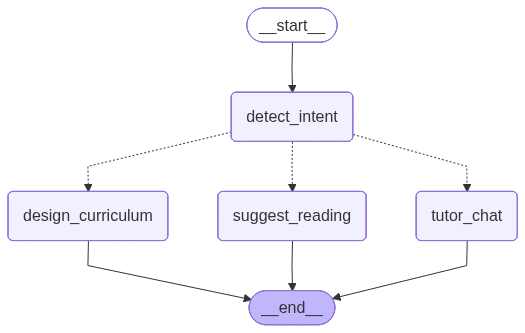

In [5]:
# 그래프 구성
from langgraph.graph import StateGraph, START, END

builder = StateGraph(ServiceState)

# 노드 추가
builder.add_node('detect_intent', detect_intent)
builder.add_node('design_curriculum', design_curriculum)
builder.add_node('suggest_reading', suggest_reading)
builder.add_node('tutor_chat', tutor_chat)

# 엣지 연결
builder.add_edge(START, 'detect_intent')
builder.add_conditional_edges(
    'detect_intent',
    select_handler,
    {
        'design_curriculum': 'design_curriculum',
        'suggest_reading': 'suggest_reading',
        'tutor_chat': 'tutor_chat'
    }
)
builder.add_edge('design_curriculum', END)
builder.add_edge('suggest_reading', END)
builder.add_edge('tutor_chat', END)

# 컴파일
graph = builder.compile()
graph

In [6]:
# 예제 실행 1: 커리큘럼 요청
result = graph.invoke({'request_text': '파이썬 입문 커리큘럼 추천해줘'})
print("\n📚 커리큘럼 결과:")
print(result['syllabus'])


📚 커리큘럼 결과:
course_title='파이썬 입문' level='초급' modules=['파이썬 소개 및 설치', '기본 문법 및 데이터 타입', '조건문과 반복문', '함수와 모듈', '리스트, 튜플, 딕셔너리', '파일 입출력', '예외 처리', '기본적인 객체지향 프로그래밍', '파이썬 라이브러리 소개 (NumPy, Pandas 등)', '간단한 프로젝트 실습']


In [7]:
# 예제 실행 2: 도서 추천
result = graph.invoke({'request_text': '자료구조 입문서 추천해줘'})
print("\n📖 도서 추천 결과:")
print(result['reading'])


📖 도서 추천 결과:
book_title='자료구조와 알고리즘 분석' author='마이클 T. 개스퍼' why_read='이 책은 자료구조와 알고리즘의 기초를 체계적으로 설명하고 있어, 초보자들이 이해하기 쉽게 구성되어 있습니다. 다양한 예제와 연습문제를 통해 실력을 쌓을 수 있으며, 이론과 실제를 연결하는 데 도움을 줍니다.'


In [8]:
# 예제 실행 3: 일반 질문
result = graph.invoke({'request_text': 'KNN 알고리즘을 간단히 설명해줘'})
print("\n💬 일반 답변 결과:")
print(result['general_note'])


💬 일반 답변 결과:
KNN(최근접 이웃 알고리즘, K-Nearest Neighbors)은 분류 및 회귀 문제에 사용되는 간단하고 직관적인 머신러닝 알고리즘입니다. KNN의 기본 아이디어는 주어진 데이터 포인트의 클래스를 결정할 때, 그와 가장 가까운 K개의 이웃 데이터 포인트를 참조하는 것입니다.

### KNN의 작동 방식:

1. **데이터 준비**: 훈련 데이터셋을 준비합니다. 각 데이터 포인트는 여러 특성(피처)과 레이블(클래스)을 가집니다.

2. **거리 측정**: 새로운 데이터 포인트가 주어지면, 훈련 데이터셋의 모든 포인트와의 거리를 계산합니다. 일반적으로 유클리드 거리(Euclidean distance)를 많이 사용하지만, 맨해튼 거리(Manhattan distance) 등 다른 거리 측정 방법도 사용할 수 있습니다.

3. **K개의 이웃 선택**: 계산된 거리 중에서 가장 가까운 K개의 이웃을 선택합니다.

4. **투표 또는 평균**:
   - **분류 문제**: K개의 이웃 중에서 가장 많이 나타나는 클래스를 선택하여 새로운 데이터 포인트의 클래스를 결정합니다.
   - **회귀 문제**: K개의 이웃의 값을 평균내어 새로운 데이터 포인트의 값을 예측합니다.

### KNN의 장점:
- 구현이 간단하고 이해하기 쉬움.
- 훈련 과정이 필요 없고, 새로운 데이터에 대해 즉시 예측 가능.

### KNN의 단점:
- 데이터가 많아질수록 계산 비용이 증가하여 느려질 수 있음.
- K 값의 선택이 결과에 큰 영향을 미침.
- 고차원 데이터에서 성능이 저하될 수 있음(차원의 저주).

KNN은 간단하면서도 효과적인 알고리즘으로, 특히 데이터가 적고 명확한 경계가 있는 경우에 잘 작동합니다.


---

## 📄 자동 보고서 생성기: 전체 구조를 쉽게 이해하기

### 🟢 단계 1: 사용자가 "보고서 주제"를 입력합니다.
예: "GPT 모델의 발전 과정"

### 🟢 단계 2: 주제에 맞춰 섹션 계획을 세웁니다.
→ 예: ① GPT-1 개요, ② GPT-2 혁신점 등

### 🟢 단계 3: 각 섹션을 동시에 작성합니다.
→ 병렬로 여러 부분을 빠르게 생성 (예: 각 챕터 초안)

### 🟢 단계 4: 작성된 내용을 하나로 병합합니다.
→ 최종 보고서 완성 🎉

📌 핵심은 "섹션 설계 → 병렬 작성 → 병합"의 흐름을 자동으로 처리하는 구조입니다.

# 📌 예제 2: Map-Reduce 보고서 생성기 (Parallel Pattern)

## 핵심 개념
- **Map**: 여러 섹션을 병렬로 작성
- **Reduce**: 작성된 섹션들을 하나로 병합
- 효율적인 병렬 처리

In [9]:
# =========================================================
# 🧩 보고서 자동 생성 시스템 - 구조 및 노드 정의
# =========================================================

import operator
from typing import Annotated, List, TypedDict
from pydantic import BaseModel, Field
from langgraph.types import Send

# =========================================================
# 1️⃣ 데이터 구조 정의
# =========================================================

# ✅ 개별 섹션의 계획 구조를 정의
class SectionPlan(BaseModel):
    title: str = Field(description="섹션 제목")       # 예: "시장 분석"
    summary: str = Field(description="한 줄 요약")    # 예: "해당 시장의 주요 트렌드를 분석"

# ✅ 전체 보고서의 계획(섹션 목록)을 정의
class ReportPlan(BaseModel):
    sections: List[SectionPlan] = Field(description="섹션 목록")

# ✅ 전체 보고서 생성 과정의 상태를 표현
class ReportState(TypedDict):
    theme: str                                      # 보고서 주제 (예: "인공지능 산업 동향")
    sections: List[SectionPlan]                     # 섹션 계획 목록
    drafted_chunks: Annotated[list, operator.add]   # 작성된 섹션 본문(리스트로 누적)
    final_report: str                               # 최종 보고서 텍스트

# ✅ 개별 섹션 단위의 하위 작업 상태를 표현
class SubTask(TypedDict):
    section: SectionPlan                            # 현재 작성 중인 섹션 정보
    drafted_chunks: Annotated[list, operator.add]   # 섹션별로 생성된 초안 누적

print("✅ 보고서 데이터 구조 정의 완료!")

✅ 보고서 데이터 구조 정의 완료!


In [10]:
# =========================================================
# 2️⃣ 섹션 계획 생성 (Outline 단계)
# =========================================================

def outline_architect(state: ReportState):
    """
    주어진 'theme(주제)'를 기반으로 보고서의 섹션 구성을 자동 생성한다.
    즉, '목차'나 '보고서 구조'를 설계하는 단계.
    """
    prompt = ChatPromptTemplate([
        ('system', '전문가 수준의 보고서 섹션 구성을 작성하세요.'),
        ('user', '주제: {theme}')
    ])

    # LLM이 ReportPlan 형태의 구조화된 출력(섹션 목록)을 생성하도록 요청
    architect = llm.with_structured_output(ReportPlan)

    # 프롬프트와 모델을 연결한 뒤 실행
    result = (prompt | architect).invoke(state)

    # 결과에서 섹션 정보만 반환
    return {"sections": result.sections}

# =========================================================
# 3️⃣ 섹션 본문 작성 (Map 단계 - 병렬 실행)
# =========================================================

def section_writer(state: SubTask):
    """
    각 섹션에 대한 상세한 본문을 작성하는 단계.
    여러 섹션이 병렬로 실행될 수 있다.
    """
    sec = state['section']

    # 섹션 정보를 기반으로 LLM에게 본문 생성을 요청
    prompt = ChatPromptTemplate([
        ('system', '섹션에 대한 상세한 내용을 작성하세요.'),
        ('user', '섹션: {title}\n요약: {summary}')
    ])

    # 프롬프트 실행 후 결과 반환
    result = (prompt | llm).invoke({'title': sec.title, 'summary': sec.summary})

    # Markdown 형식의 섹션 헤더 포함
    return {"drafted_chunks": [f"## {sec.title}\n\n{result.content}"]}

# =========================================================
# 4️⃣ 병렬 작업 분배 (Dispatch 단계)
# =========================================================

def dispatch_writers(state: ReportState):
    """
    각 섹션을 개별적으로 'section_writer' 노드에 전달하여 병렬로 실행한다.
    즉, 섹션별 글쓰기를 동시에 처리하기 위한 분배 함수.
    """
    # 각 섹션을 Send 객체로 감싸 반환 → 병렬 실행 가능
    return [Send("section_writer", {"section": s}) for s in state["sections"]]

# =========================================================
# 5️⃣ 최종 병합 (Reduce 단계)
# =========================================================

def merger(state: ReportState):
    """
    모든 섹션 초안들을 하나의 최종 보고서로 병합하는 단계.
    """
    # 작성된 섹션들을 순서대로 합치기
    final = "\n\n".join(state["drafted_chunks"])

    # 최종 보고서 반환
    return {"final_report": final}

print("✅ 보고서 생성 노드 정의 완료!")

✅ 보고서 생성 노드 정의 완료!


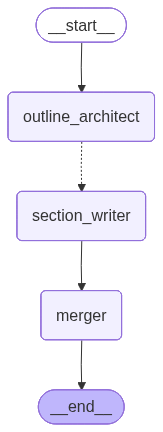

In [11]:
# 그래프 구성
report_builder = StateGraph(ReportState)

# 노드 추가
report_builder.add_node("outline_architect", outline_architect)
report_builder.add_node("section_writer", section_writer)
report_builder.add_node("merger", merger)

# 엣지 연결
report_builder.add_edge(START, "outline_architect")
report_builder.add_conditional_edges(
    "outline_architect",
    dispatch_writers,
    ["section_writer"]
)
report_builder.add_edge("section_writer", "merger")
report_builder.add_edge("merger", END)

# 컴파일
report_flow = report_builder.compile()
report_flow


In [12]:
# 예제 실행: 보고서 생성
result = report_flow.invoke({"theme": "인공지능의 발전 과정"})

print("\n" + "="*60)
print("📄 최종 보고서")
print("="*60)
print(result['final_report'])


📄 최종 보고서
## 서론

### 서론

인공지능(AI)은 컴퓨터 시스템이 인간의 지능을 모방하여 학습, 추론, 문제 해결, 언어 이해 등의 작업을 수행할 수 있도록 하는 기술을 의미합니다. AI는 머신러닝, 딥러닝, 자연어 처리 등 다양한 하위 분야로 나뉘며, 이러한 기술들은 데이터 분석, 이미지 인식, 자율주행차, 의료 진단 등 여러 산업 분야에서 혁신을 이끌고 있습니다. AI의 발전은 우리의 일상생활을 변화시키고 있으며, 기업의 운영 방식과 사회 전반에 걸쳐 큰 영향을 미치고 있습니다.

AI의 중요성은 단순히 기술적 진보에 그치지 않고, 경제적, 사회적, 윤리적 측면에서도 깊은 의미를 지닙니다. AI는 생산성을 높이고, 새로운 비즈니스 모델을 창출하며, 인간의 삶의 질을 향상시키는 데 기여할 수 있습니다. 그러나 동시에 AI의 발전은 개인정보 보호, 일자리 대체, 윤리적 결정 등 여러 도전 과제를 동반하고 있어, 이에 대한 심도 있는 논의가 필요합니다.

본 보고서는 인공지능의 정의와 중요성을 바탕으로, AI 기술의 현재와 미래, 그리고 그에 따른 사회적 영향과 윤리적 고려사항을 다루고자 합니다. 보고서는 다음과 같은 구성으로 진행됩니다. 첫째, AI의 기술적 발전과 응용 사례를 살펴보고, 둘째, AI가 가져올 사회적 변화와 경제적 영향에 대해 논의하며, 셋째, AI의 윤리적 문제와 해결 방안에 대해 제안할 것입니다. 이를 통해 독자들이 AI의 복합적인 측면을 이해하고, 향후 AI 기술이 나아가야 할 방향에 대한 통찰을 얻을 수 있도록 하는 것이 본 보고서의 목표입니다.

## 인공지능의 역사

### 인공지능의 역사

인공지능(AI)의 역사는 20세기 중반부터 시작되어 현재에 이르기까지 다양한 발전과 변화를 겪어왔습니다. 이 섹션에서는 인공지능의 발전 과정을 시대별로 정리하고, 주요 사건과 인물들을 소개합니다.

#### 1. 초기 개념과 이론 (1940년대 - 1950년대)
- **앨런 튜링**: 1950년, 튜링은 "Computing Machi